In [1]:
# Libraries
import scipy.io as sio
import numpy as np
from scipy.signal import find_peaks
from os.path import dirname, join as pjoin
import sys
import datetime
import matplotlib.pyplot as plt
import copy

# Tools I've developed along the way to aid the project
import sys
sys.path.insert(1,'../')
import Tools.data_processing as dp
import Tools.data_movement as dm 
from auxiliary_functions import extract_runoff


fDOM_raw_data = dm.read_in_preprocessed_timeseries('/Users/zachfogg/Desktop/DB-SRRW/Data/converted_data/julian_format/fDOM_raw_10.1.2011-9.4.2020.csv')
stage_data = dm.read_in_preprocessed_timeseries('/Users/zachfogg/Desktop/DB-SRRW/Data/converted_data/julian_format/stage_10.1.11-1.1.19.csv')
turb_data = dm.read_in_preprocessed_timeseries('/Users/zachfogg/Desktop/DB-SRRW/Data/converted_data/julian_format/turbidity_raw_10.1.2011_9.4.2020.csv')

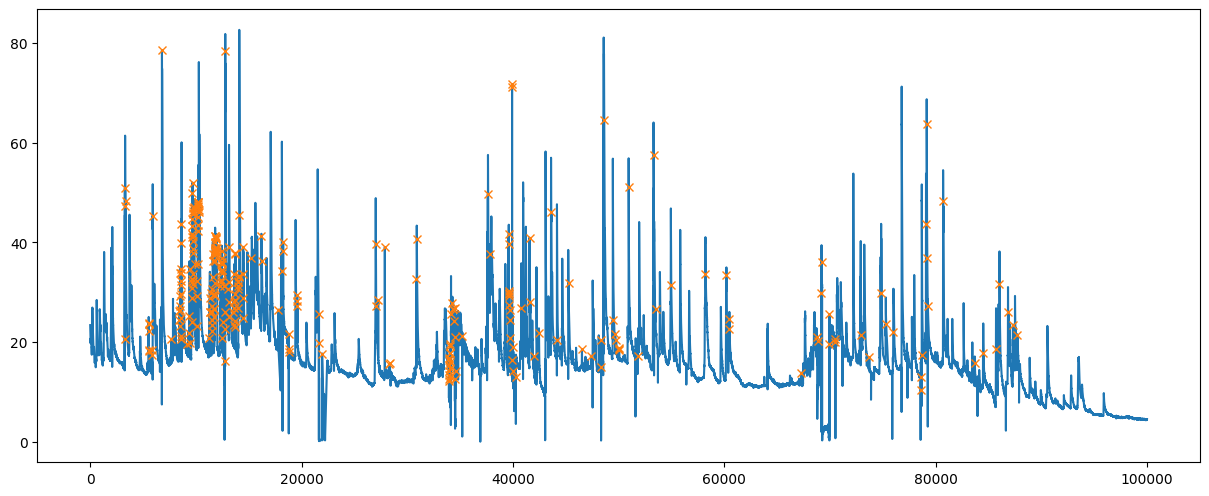

In [2]:
# Sharp peaks algo

# Manually determine some generous ranges for prominence, width, wlen, possibly threshold, possibly distance to segment out fluctuations, rel_height for basewidth
# Prominence range: (2,None), rel_height = 1.0 (maybe .9 but not .5), width: (None, 20), wlen = 100 (to save on efficieny), distance = 5 (this will prevent fluctuations from being detected)
# For distance we also have to consider that a sharp peak could occur mid event? 
# Threshold will not be useful it seems like
prominence_range_sky = [2,None]
width_range_sky = [None,20]
wlen_sky = 100
distance_sky = 4 
rel_height_sky =.8

# data = fDOM_raw_data[:100000][:,1]

# Get list of all peaks that could possibly be sharp peaks
possible_sky_peaks, props_sky = find_peaks(fDOM_raw_data[:,1],
                          height = (None, None),
                          threshold = (None,None),
                          distance = distance_sky,
                          prominence = prominence_range_sky,
                          width = width_range_sky,
                          wlen = wlen,
                          rel_height = rel_height_sky)

# Algo that relies on basewidth and prominence

# Convert detected anomalies to 'event' style to then plot to trainset

plt.figure(figsize=(15,6),dpi=100)
plt.plot(data)
plt.plot(possible_sky_peaks, data[possible_sky_peaks],'x')

In [3]:
def detected_peak_to_event(data: np.ndarray, left_ips: float, right_ips: float):
    # Use left_ips, right_ips to determine start and end of event 
    left_ips = round(left_ips)
    right_ips = round(right_ips)
    event = []
    for i in range(left_ips, right_ips+1):
        event.append(data[i])
    return np.array(event)

# Iterate through peaks and write to list 
events = []
for i in range(len(props['left_ips'])):
    events.append(detected_peak_to_event(fDOM_raw_data,props['left_ips'][i],props['right_ips'][i]))

In [67]:
# Call trainset plotting functions to see what events were captured

missing_file_path = '/Users/zachfogg/Desktop/DB-SRRW/Data/Misc/delete_date_ranges.txt'
# events = dp.delete_missing_data_events(events,missing_file_path)
# turb_events= dp.delete_missing_data_events(turb_events,missing_file_path)
# stage_events = dp.delete_missing_data_events(stage_events, missing_file_path)

# These determine what labels the events will be assigned
flags = {
    "fDOM_flag" : "normal_peak",
    "default_fDOM_flag" : "",
    "stage_flag" : "normal_peak",
    "default_stage_flag" : "",
    "turb_flag" : "normal_peak",
    "default_turb_flag" : ""
}
dm.write_detected_to_trainset(events, 
                        stage_events, 
                        turb_events, 
                        fDOM_raw_data,
                        stage_data, 
                        turb_data,
                        flags,
                        '/Users/zachfogg/Desktop/DB-SRRW/Data/anomaly_data/Trainset_Compliant/sharp_peaks100k.csv',
                        0,100000)

In [68]:
for key in props:
    print(key)

peak_heights
left_thresholds
right_thresholds
prominences
left_bases
right_bases
widths
width_heights
left_ips
right_ips


In [ ]:
def detect_sky_peaks_fDOM(candidates: list[np.ndarray], 
                            properties: list, prom_range: 
                            list[float], base_width_range: 
                            list[float]) -> list[list[list]]:
    """
    Detect fDOM sharp peak anomalies from given set of possible candidates, given hyper parameters 
    """
    sharp_peaks = []
    not_sharp_peaks = []
    
    for i, peak in candidates:
        # Uses bases to calculate base_width. Or just use width. Is width a float or in
        base_width = properties['right_bases'][i] - properties['left_bases'][i]
        base_width = properties['widths'][i]
        prominence = properties['prominences'][i]
        start_timestamp = data[properties['left_bases'][i],0]
        end_timestamp = data[properties['right_bases'][i],0]
        peak_timestamp = data[peak][0]
        
        # Check if base_width violates
        if ((base_width > base_width_range[0] and base_width < base_width_range[1])
            and prominence > prom_range[0] and prominence < prom_range[1]):
            
            # Append [start, end, peak, label]
            sharp_peaks.append([start_timestamp,end_timestamp,peak_timestamp,'sharp_peak_fDOM'])
            
        else: 
            not_sharp_peaks.append([start_timestamp,end_timestamp,peak_timestamp,'rejected_sharp_peak_fDOM'])
    return [sharp_peaks, not_sharp_peaks]

In [5]:
# flip timeseries 
flipped_fDOM = np.array(fDOM_raw_data)
flipped_fDOM = dp.flip_timeseries(flipped_fDOM)

# get candidates with find_peaks 
prominence_range_plum = [3,None]
width_range_plum = [None,5]
wlen_plum = 100
distance_plum = 1 
rel_height_plum =.6

data = fDOM_raw_data[:100000][:,1]

# Get list of all peaks that could possibly be plummeting peaks
possible_plum_peaks, props = find_peaks(data,
                          height = (None, None),
                          threshold = (None,None),
                          distance = distance_plum,
                          prominence = prominence_range_plum,
                          width = width_range_plum,
                          wlen = wlen_plum,
                          rel_height = rel_height_plum)

# get list of turb_peaks: these turb peaks look similar to skyrocketing peaks in fDOM. 
prominence_range_turb = [2,None]
width_range_turb = [None,10]
wlen_turb = 100
distance_turb = 1 
rel_height_turb =.8

data = fDOM_raw_data[:100000][:,1]

# Get list of all peaks that could possibly be sharp peaks
turb_peaks, props = find_peaks(data,
                          height = (None, None),
                          threshold = (None,None),
                          distance = distance_turb,
                          prominence = prominence_range_turb,
                          width = width_range_turb,
                          wlen = wlen_turb,
                          rel_height = rel_height_turb)

In [ ]:
julian_hour = 0.04166666651144624
interference_hour_range = [julian_hour * 2]
prom_range = []
base_width_range = []

plummeting_peaks, not_plummeting_peaks = detect_plum_peaks_fDOM(possible_plum_peaks,
                                                                turb_peaks,
                                                                interference_hour_range,
                                                                props)

In [ ]:
# get turb peaks 
def detect_plum_peaks_fDOM(candidates: list[np.ndarray],
                           turb_peaks: list[list[list]],
                           interference_hour_range: list[int]
                           properties: list, 
                           prom_range: list[float], 
                           base_width_range: list[float]):
    """
    Detect fDOM plummeting peak anomalies from given set of possible candidates, given hyper parameters and turb peaks
    """
    plum_peaks = []
    not_plum_peaks = []
    interference_peaks = [] # label these so we can see if it is rejecting correctly
    
    for i, peak in candidates:
        # Uses bases to calculate base_width. Or just use width. Is width a float or in
        base_width = properties['right_bases'][i] - properties['left_bases'][i]
        base_width = properties['widths'][i]
        prominence = properties['prominences'][i]
        start_timestamp = data[properties['left_bases'][i],0]
        end_timestamp = data[properties['right_bases'][i],0]
        peak_timestamp = data[peak][0]
        
        # Check if base_width violates
        if ((base_width > base_width_range[0] and base_width < base_width_range[1])
            and prominence > prom_range[0] and prominence < prom_range[1]):
            
            # Check for interference
            for peak in turb_peaks: 
                # Check if fDOM peak is within x hours of turb peak
                if condition: 
                    # Append to interference_peaks
                    break
            # Append [start, end, peak, label]
            plum_peaks.append([start_timestamp,end_timestamp,peak_timestamp,'plum_peak_fDOM'])
            
        else: 
            not_sharp_peaks.append([start_timestamp,end_timestamp,peak_timestamp,'rejected_plum_peak_fDOM'])
    return sharp_peaks, not_sharp_peaks
    
    pass

In [ ]:
plum_peaks = []
def filter_fDOM_cands(peaks, props,fDOM_data):
    """
    Filter out candidates with an extremely small ending slope 
    Filter out candidates whose start and end occur on a plummenting peak/interference
    """
    take_indices = []
    
    end_thresh = .2
    for i, peak in enumerate(peaks): 
        if peak > 100000:
            break
        end_run = abs(peak - math.ceil(props['right_ips'][i]))
        end_rise = abs(fDOM_data[peak,1] - fDOM_data[math.ceil(props['right_ips'][i]),1])  
        end_slope = end_rise/end_run

        if end_slope < end_thresh:
            print('Date: {} ES: {}  Prom: {}'.format(dp.julian_to_datetime(fDOM_data[peak,0]), round(end_slope,3),round(props['prominences'][i],2)))
            print('Left IPS: {}'.format(dp.julian_to_datetime(fDOM_data[math.ceil(props['right_ips'][i]),0])))
            print('\n')
        
        if math.ceil(props['right_ips'][i]) in plum_peaks and math.floor(props['left_ips'][i]) in plum_peaks:
            print('DQP: Data: {}'.format(dp.julian_to_datetime(fDOM_data[peak,0])))
        
filter_fDOM_cands(fDOM_peaks, fDOM_props, fDOM_raw_data)

flipped_fDOM = np.array(fDOM_raw_data)
flipped_fDOM = dp.flip_timeseries(flipped_fDOM)